In [1]:
import numpy as np
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
from iexfinance.stocks import get_historical_data
import iexfinance as iex

In [4]:
IEX_API_VER = os.environ['IEX_API_VERSION']
IEX_TOKEN = os.environ['IEX_TOKEN'] 
#IEX_ID = os.getenv('IEX_API_KEY')
#IEX_PUBLIC_KEY = os.getenv('IEX_PUBLIC_KEY')

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
# set the list of tickers
list_of_tickers = ["SPY", "AGG"]

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for SPY & AGG
df = get_historical_data(list_of_tickers, start_date, end_date, output_format='pandas')

df.head()


SPY                                       AGG                  \
              open    high     low   close    volume    open    high     low   
date                                                                           
2019-04-22  290.40  295.93  291.71  295.43  41986175  108.76  111.83  109.21   
2019-04-23  294.12  302.83  290.42  298.26  52647331  109.90  110.89  109.78   
2019-04-24  294.19  296.51  295.11  306.34  52005688  111.43  108.90  109.95   
2019-04-25  304.72  297.14  294.54  299.69  60008702  109.77  109.07  111.42   
2019-04-26  295.80  299.25  300.28  295.15  51611993  113.53  112.81  112.54   

                             
             close   volume  
date                         
2019-04-22  108.35  5801909  
2019-04-23  113.29  3436592  
2019-04-24  113.30  3129368  
2019-04-25  112.19  2748631  
2019-04-26  110.45  2344244

In [6]:
# Use the `drop` function with the `level` parameter to drop extra columns in the multi-index DataFrame
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head()

,SPY,AGG
,close,close
date,,
2019-04-22,295.43,108.35
2019-04-23,298.26,113.29
2019-04-24,306.34,113.30
2019-04-25,299.69,112.19
2019-04-26,295.15,110.45


In [7]:
df = df.droplevel(1, axis=1)
df.head()

,SPY,AGG
date,,
2019-04-22,295.43,108.35
2019-04-23,298.26,113.29
2019-04-24,306.34,113.30
2019-04-25,299.69,112.19
2019-04-26,295.15,110.45


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [8]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change().dropna()
avg_daily_returns=daily_returns.mean()
avg_daily_returns

SPY    0.000335
AGG    0.000522
dtype: float64

In [9]:
# Calculate volatility
# Use the `std` function to calculate the standard deviation of daily returns for `SPY` and `AGG`, respectively
standard_deviation = daily_returns.std()
standard_deviation

SPY    0.028511
AGG    0.019800
dtype: float64

In [10]:
# Save the last day's closing price
closing_price = {}
for ticker in list_of_tickers:
    closing_price[ticker] = df.iloc[-1][ticker]
closing_price

{'SPY': 290.14, 'AGG': 117.57}

In [11]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30

# Set the portfolio weights
weights = [0.60, 0.40]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()


In [12]:
# Run the simulation of projecting stock prices for the next 30 year
for n in range(number_simulations):
    
    # Iterate through each ticker
    for ticker in list_of_tickers:
        
        # Initialize the simulated prices list with the last closing price
        simulated_prices = [closing_price[ticker]]
        
        # Simulate the returns for 252 days
        for i in range(number_records):

            # Calculate the simulated price using the last price within the list
            simulated_price = simulated_prices[-1] * (1 + np.random.normal(avg_daily_returns[ticker], standard_deviation[ticker]))
            
            # Append the simulated price to the list
            simulated_prices.append(simulated_price)
        
        # Append a simulated prices of each simulation to DataFrame
        simulated_price_df[ticker] = pd.Series(simulated_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
     
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
    

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996768,0.975424,0.973037,0.981965,1.014317,1.025220,1.029947,0.973974,0.999204,0.996184,...,0.999504,0.985215,1.032683,0.991299,0.989426,1.007653,0.989128,0.970275,1.018240,1.012126
2,0.985910,0.968807,0.966761,1.000145,1.056014,0.997622,1.011426,1.024089,0.991199,0.983857,...,1.004515,0.958450,1.036740,1.011069,0.975780,1.026275,1.002301,0.997340,1.003159,0.991290
3,1.004830,0.974468,0.947834,0.992684,1.063124,0.969136,0.969800,0.987423,0.989209,1.018286,...,1.009150,0.978857,1.046051,1.015429,0.970031,1.022987,0.991757,0.995825,1.004439,1.017046
4,1.038368,0.985946,0.949382,0.960170,1.060089,0.970503,0.962600,0.970224,0.984173,1.008417,...,1.013314,0.973423,1.063459,1.020583,0.966648,0.965262,0.998685,0.977055,1.009338,1.023091


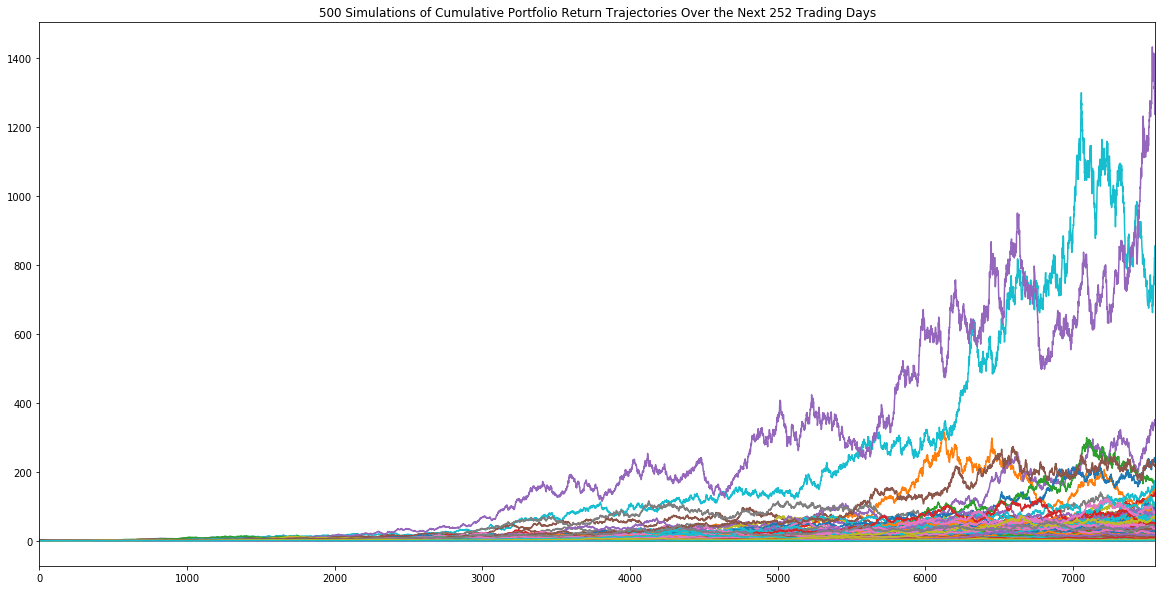

In [13]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(figsize=(20,10), legend=None, title=plot_title)

In [14]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.tail()

495    215.587814
496      1.367381
497     42.094818
498      5.072427
499      2.315808
Name: 7560, dtype: float64

In [15]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
years_20_cumulative_returns = portfolio_cumulative_returns.iloc[(20*252),:]
years_20_cumulative_returns

0       4.899328
1      13.434028
2       1.881245
3       1.110923
4      15.268839
5       7.429415
6       2.183180
7      33.791232
8       1.814753
9       3.426637
10      2.013847
11      9.525769
12      0.775977
13      0.680566
14      9.632017
15      6.418877
16      1.571053
17      8.166050
18     14.601370
19      0.247850
20      0.132897
21     43.924549
22      3.761392
23      5.442855
24      4.027697
25     30.749748
26      0.302561
27      0.683239
28      4.355718
29      1.600341
         ...    
470     2.196189
471     3.126194
472     5.597035
473     1.122801
474     0.462579
475     1.981304
476     1.827432
477     1.646082
478     3.616624
479     4.512352
480     3.677873
481     3.030257
482     0.507076
483     2.636690
484     3.248676
485    15.340100
486    10.125173
487     7.005275
488    10.560607
489    10.777269
490     2.226129
491     3.540048
492     0.592330
493     5.363873
494     2.071150
495    51.318953
496     3.153759
497    19.7110

In [16]:
# Use the `quantile` function to calculate the 90% confidence interval for simulated ending prices
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05     0.327229
0.95    65.275294
Name: 7560, dtype: float64

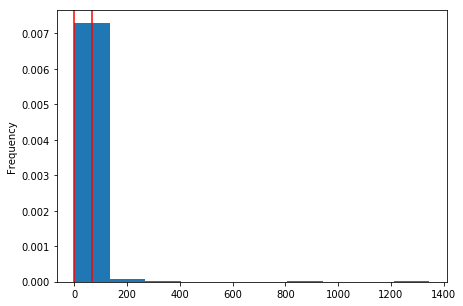

In [17]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(figsize=(7,5), kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [18]:
expected_cum_returns_30 = ending_cumulative_returns.quantile(q=[0.1,0.5, 0.9]).round(2)
print('Expected Cumulative Return at 30 year')
print(f'10th Percentile  : {expected_cum_returns_30[0.1]}')
print(f'50th Percentile  : {expected_cum_returns_30[0.5]}')
print(f'90th Percentile  : {expected_cum_returns_30[0.9]}')

Expected Cumulative Return at 30 year
10th Percentile  : 0.72
50th Percentile  : 5.56
90th Percentile  : 39.22


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [19]:
initial_investment = 20000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returnsinitial_investment * confidence_interval_1
expected_portfolio_returns = (expected_cum_returns_30 * initial_investment).round(2)

print('Expected Portfolio Return at 30 year')
print(f'10th Percentile  : {expected_portfolio_returns[0.1]}$')
print(f'50th Percentile  : {expected_portfolio_returns[0.5]}$')
print(f'90th Percentile  : {expected_portfolio_returns[0.9]}$')

Expected Portfolio Return at 30 year
10th Percentile  : 14400.0$
50th Percentile  : 111200.0$
90th Percentile  : 784400.0$


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [20]:
#Projected Annual Income = $6085
four_pct_return = round(0.04*expected_portfolio_returns[0.1])
four_pct_return

576.0

In [21]:
# The current projected annual income from Plaid Analysis
projected_annual_income = 6085.0

# Checks whether 4% return in retirement portfolio meets Projected annual income
status = 'does meet' if four_pct_return>projected_annual_income else 'doesn\'t meet'

print(f'The current projected annual income is {int(projected_annual_income)}$, 4% withdraw rate from the retirement portfolio is {int(four_pct_return)}$ {status} the value at the 10th percentile')

The current projected annual income is 6085$, 4% withdraw rate from the retirement portfolio is 576$ doesn't meet the value at the 10th percentile


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [24]:
# Initial investment after 50% increase in the original investment
initial_investment_new = initial_investment * 1.5

# Calculate the 4% return for new initial investment
new_cumulative_return = round(.04*(initial_investment_new * ending_cumulative_returns.quantile(0.1)),2)

# Checks whether 4% return in retirement portfolio meets Projected annual income
if new_cumulative_return > projected_annual_income:
    print(f'4% withdrawal rate from the retirement portfoio {new_cumulative_return} will meet the value of projected income')
else:
    print(f'4% withdrawal rate from the retirement portfolio {new_cumulative_return} will not meet the value of projected income')
    

4% withdrawal rate from the retirement portfolio 865.28 will not meet the value of projected income


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the 5%, 50%, and 95% quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.


###### YOUR CODE HERE

[Text(0, 0.5, 'Portfolio Return'), Text(0.5, 0, 'No of Days')]

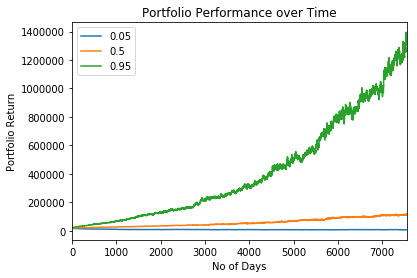

In [25]:
df1 = portfolio_cumulative_returns * initial_investment
ax = df1.swapaxes("index", "columns").quantile([0.05, 0.5, 0.95]).swapaxes('index', 'columns').plot(title='Portfolio Performance over Time')
ax.set(xlabel='No of Days', ylabel='Portfolio Return')